***Bicing data***



**Getting Started**

Loading Python session, importing PySpark, and loading respective Spark packages. Declaring Spark Session for pulling and analyzing data:

In [223]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import matplotlib.pyplot as plt
import pandas as pd
import math
from geopy.distance import geodesic

warehouseLocation = "D:\ThomasData\Documents"

spark = SparkSession \
    .builder \
    .appName("example") \
    .config("spark.sql.warehouse.dir", warehouseLocation) \
    .enableHiveSupport() \
    .getOrCreate()


**Loading Data**

Loading in sample data as dataframe provided from email and creating view for analysis from table. This will require editing the schema to ensure our features are read in correctly:

In [259]:
path = 'D:\ThomasData\Documents\Bicing.json'
df = spark.read.json(path).cache()
print("Original Schema")
df.printSchema()
df = df.withColumn("altitude",df["altitude"].cast(DoubleType()))
df = df.withColumn("bikes",df["bikes"].cast(IntegerType()))
df = df.withColumn("latitude",df["latitude"].cast(DoubleType()))
df = df.withColumn("longitude",df["longitude"].cast(DoubleType()))
df = df.withColumn("slots",df["slots"].cast(IntegerType()))

df = df.withColumn(
    "nearbyStations",
    split(col("nearbyStations"), ",\s*").cast("array<int>").alias("nearbyStations")
)

print("New Schema")
df.printSchema()
print("Data Shape")
print((df.count(), len(df.columns)))

Original Schema
root
 |-- altitude: string (nullable = true)
 |-- bikes: string (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- nearbyStations: string (nullable = true)
 |-- slots: string (nullable = true)
 |-- status: string (nullable = true)
 |-- streetName: string (nullable = true)
 |-- streetNumber: string (nullable = true)
 |-- type: string (nullable = true)

New Schema
root
 |-- altitude: double (nullable = true)
 |-- bikes: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- nearbyStations: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- slots: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- streetName: string (nullable = true)
 |-- streetNumber: string (nullable = true)
 |-- type: string (nullable = true)

Data Shape
(465, 11)


**Subsetting and Temp Views**

We will now show 3 out of the 11 columns using *spark's select and show* commands. We will also create a temp view with the last dataframe:

In [104]:
df.select(df['id'],df['bikes'],df['slots']).show()
df.createOrReplaceTempView("bicing")

+---+-----+-----+
| id|bikes|slots|
+---+-----+-----+
|  1|    1|   21|
|  2|    2|   24|
|  3|   15|   10|
|  4|    9|   10|
|  5|    2|   36|
|  6|    7|   31|
|  7|    4|   20|
|  8|    2|   25|
|  9|    4|   13|
| 10|    2|   28|
| 11|   17|    4|
| 12|   29|    1|
| 13|   30|    3|
| 14|    2|   19|
| 15|    3|   16|
| 16|    3|   18|
| 17|    3|   18|
| 18|   22|   10|
| 19|   10|   18|
| 20|    6|   13|
+---+-----+-----+
only showing top 20 rows



**Using Spark SQL** 

We will demonstrate the ability to select the same features leveraging *Spark SQL*:


In [79]:
spark.sql("SELECT id, bikes, slots FROM bicing").show()
spark.sql("SELECT sum(bikes) AS bike_count, type AS bike_types FROM bicing GROUP BY bike_types").show()

+---+-----+-----+
| id|bikes|slots|
+---+-----+-----+
|  1|    1|   21|
|  2|    2|   24|
|  3|   15|   10|
|  4|    9|   10|
|  5|    2|   36|
|  6|    7|   31|
|  7|    4|   20|
|  8|    2|   25|
|  9|    4|   13|
| 10|    2|   28|
| 11|   17|    4|
| 12|   29|    1|
| 13|   30|    3|
| 14|    2|   19|
| 15|    3|   16|
| 16|    3|   18|
| 17|    3|   18|
| 18|   22|   10|
| 19|   10|   18|
| 20|    6|   13|
+---+-----+-----+
only showing top 20 rows

+----------+-------------+
|bike_count|   bike_types|
+----------+-------------+
|       259|BIKE-ELECTRIC|
|      3903|         BIKE|
+----------+-------------+



**Using Spark SQL (cont.)**

As seen above, there are  **259 electric bikes**, and **3,903 mechanical bikes**. Let's now count bike including availability throughout the system: 

In [257]:
spark.sql("SELECT count(id) AS station_count, type AS bike_types, status FROM bicing GROUP BY bike_types, status ORDER BY bike_types").show()
spark.sql("SELECT sum(bikes) AS bike_count, type AS bike_types, status FROM bicing GROUP BY bike_types, status ORDER BY bike_types").show()

+-------------+-------------+------+
|station_count|   bike_types|status|
+-------------+-------------+------+
|            1|         BIKE|   CLS|
|          418|         BIKE|   OPN|
|            4|BIKE-ELECTRIC|   CLS|
|           42|BIKE-ELECTRIC|   OPN|
+-------------+-------------+------+

+----------+-------------+------+
|bike_count|   bike_types|status|
+----------+-------------+------+
|         0|         BIKE|   CLS|
|      3903|         BIKE|   OPN|
|         0|BIKE-ELECTRIC|   CLS|
|       259|BIKE-ELECTRIC|   OPN|
+----------+-------------+------+



It appears that there is only one location that is closed which handles mechanical bikes; additionally, it appears that there are 4 locations which are closed handling electric bikes. We can also see that bikes are not counted if the location is closed. Let's move on.

**Data Visualization**

Let's visualize this plot to understand fully what's going on. Pyspark is helpful, because it contains functions to map objects back to a python-based package. We can do this by declaring a new dataframe in a pandas format, then visualizing that table:

Text(0, 0.5, 'Bikes')

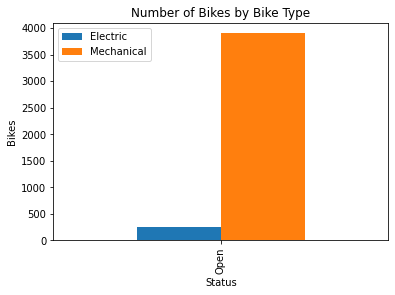

In [88]:
dfP_1 = spark.sql("SELECT sum(bikes) AS bike_count, type AS bike_types, status FROM bicing GROUP BY bike_types, status ORDER BY bike_types").toPandas()
plotdata = pd.DataFrame({
    "Electric": [259],
    "Mechanical": [3903]
    }, 
    index=["Open"]
)
plotdata.plot(kind="bar")
plt.title("Number of Bikes by Bike Type")
plt.xlabel("Status")
plt.ylabel("Bikes")

Great - now we can visually see the count of electric and mechanical bikes that are available. Let's now take a look at available bike slots:

+----------+-------------+------+
|slot_count|   bike_types|status|
+----------+-------------+------+
|        21|         BIKE|   CLS|
|      6583|         BIKE|   OPN|
|        46|BIKE-ELECTRIC|   CLS|
|       281|BIKE-ELECTRIC|   OPN|
+----------+-------------+------+



Text(0, 0.5, 'Bikes')

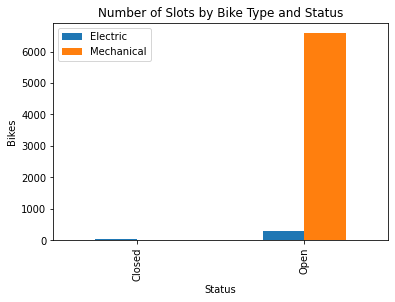

In [90]:
spark.sql("SELECT sum(slots) AS slot_count, type AS bike_types, status FROM bicing GROUP BY bike_types, status ORDER BY bike_types").show()
dfP_2 = spark.sql("SELECT sum(slots) AS slot_count, type AS bike_types, status FROM bicing GROUP BY bike_types, status ORDER BY bike_types").toPandas()
plotdata = pd.DataFrame({
    "Electric": [46, 281],
    "Mechanical": [21, 6583]
    }, 
    index=["Closed", "Open"]
)
plotdata.plot(kind="bar")
plt.title("Number of Slots by Bike Type and Status")
plt.xlabel("Status")
plt.ylabel("Bikes")

**Additional SQL Commands and Loading**

We will now explore additional SQL commands and creating additional tables. Let's start by honing in on a specific bicing location (*ID 1*), and counting the bikes there:

In [94]:
spark.sql("SELECT sum(bikes) AS bike_count, status FROM bicing WHERE id = 1 GROUP BY status").show()

+----------+------+
|bike_count|status|
+----------+------+
|         1|   OPN|
+----------+------+



Great. Let's now make a copy of the view bicing:

In [122]:
df2 = df
df2.createOrReplaceTempView("bicing2")


Now that we've made a copy, let's verify that number of bikes matches the original dataframe. We will also make sure that *ID 1* has the same amount of bikes in our copy:

In [123]:
spark.sql("SELECT sum(bikes) FROM bicing").show()
spark.sql("SELECT sum(bikes) FROM bicing2").show()
spark.sql("SELECT sum(bikes) FROM bicing2 WHERE id = 1").show()

+----------+
|sum(bikes)|
+----------+
|      4162|
+----------+

+----------+
|sum(bikes)|
+----------+
|      4162|
+----------+

+----------+
|sum(bikes)|
+----------+
|         1|
+----------+



We're good to go here. Let's try updating the *bicing2* table now by using a similar method (using some of Spark's functions) - we will update the location with the *ID 1* so it now has 11 bikes:

In [260]:
df2=df2.withColumn("bikes", when(df2["id"] == 1, 11).otherwise(df2["bikes"]))
df2.select(df2['id'],df2['bikes']).show()

+---+-----+
| id|bikes|
+---+-----+
|  1|   11|
|  2|    2|
|  3|   15|
|  4|    9|
|  5|    2|
|  6|    7|
|  7|    4|
|  8|    2|
|  9|    4|
| 10|    2|
| 11|   17|
| 12|   29|
| 13|   30|
| 14|    2|
| 15|    3|
| 16|    3|
| 17|    3|
| 18|   22|
| 19|   10|
| 20|    6|
+---+-----+
only showing top 20 rows



Excellent - now the location with the *ID* of *1* now reflects 11 bikes. Let's try adding 1 additional bike to all *available (or open) locations*. We could technically add bikes to stations indicated as **CLS**; however, I think that would violate our business rules (and realistically wouldn't be a smart allocation of resources):

In [261]:
df2=df2.withColumn("bikesAddOne", when(df2["status"] == "OPN", df2["bikes"] + 1).otherwise(df2["bikes"]))
df2.select(df2["id"], df2["bikesAddOne"]).show()
df2.createOrReplaceTempView("bicing2")

+---+-----------+
| id|bikesAddOne|
+---+-----------+
|  1|         12|
|  2|          3|
|  3|         16|
|  4|         10|
|  5|          3|
|  6|          8|
|  7|          5|
|  8|          3|
|  9|          5|
| 10|          3|
| 11|         18|
| 12|         30|
| 13|         31|
| 14|          3|
| 15|          4|
| 16|          4|
| 17|          4|
| 18|         23|
| 19|         11|
| 20|          7|
+---+-----------+
only showing top 20 rows



Observing the above - our new dataframe has an additional column with one added to each *bikes value* to all available stations. If we wanted to, we could techinically drop the original column in *bicing2* **bikes** by implementing the **df2.drop('bikes').collect()** command - using Apache Spark. This would then only leave us with our new column; for this example, I will skip this step. Let's go ahead and verify that our newly created column reflects the difference that we added when compared to its original dataframe **bicing**.

Recalling from our past query, there are **460** open stations. We also added replaced the first station's *1 bike value to 11*. So all in all, we should have **470 extra bikes** in comparison.

In [154]:
x=spark.sql("SELECT sum(bikesAddOne) from bicing2").toPandas()
y=spark.sql("SELECT sum(bikes) from bicing").toPandas()
x.iloc[0,0] - y.iloc[0,0]

470

Awesome! Now that we've verified our data transformation, let's continue with one more SQL task:

In [156]:
df3 = df
df3=df3.withColumn("bikes", when(df3["id"] == 1, df3["bikes"] + 10).otherwise(df3["bikes"]))
df3.select(df3['id'], df3['bikes']).show()

+---+-----+
| id|bikes|
+---+-----+
|  1|   11|
|  2|    2|
|  3|   15|
|  4|    9|
|  5|    2|
|  6|    7|
|  7|    4|
|  8|    2|
|  9|    4|
| 10|    2|
| 11|   17|
| 12|   29|
| 13|   30|
| 14|    2|
| 15|    3|
| 16|    3|
| 17|    3|
| 18|   22|
| 19|   10|
| 20|    6|
+---+-----+
only showing top 20 rows



We've conducted the same task as when we updated this value in df2; however, *we've changed the operation*.

**Additional Analysis**

After observing this dataframe, I want to further explore the *nearbyStations* column. Let's go through an exercise of verifying this array of nearby stations. This can be done by conducting the following:

-Starting with location having the *ID of 1*, let's seperate the array containing all of its nearby locations (this would include stations: *24, 369, 387, and 426*)

-Next, we can fetch the *latitude and longitude* of each location, and then compute the **Cartesian Distance** using Python's **GeoPy: geodesic** from each stations' location to *ID 1*

-If the 4 smallest **Location Distances** are matched to the nearby locations, I will be satisfied with the column


In [243]:
nearby1 = spark.sql("SELECT nearbyStations FROM bicing WHERE id = 1").toPandas()
lat1, lon1, alt1 = spark.sql("SELECT latitude FROM bicing WHERE id = 1").toPandas(), spark.sql("SELECT longitude FROM bicing WHERE id = 1").toPandas(), spark.sql("SELECT altitude FROM bicing WHERE id = 1").toPandas()
allCoordinates = spark.sql("SELECT id, latitude, longitude, altitude FROM bicing").toPandas()

nearby1_ = nearby1.iloc[0,0]
lat1_ = lat1.iloc[0,0]
lon1_ = lon1.iloc[0,0]
alt1_ = alt1.iloc[0,0]
id1_ = (lat1_,lon1_)

print(nearby1, lat1_, lon1_, alt1, id1_)
allCoordinates.head()

        nearbyStations
0  [24, 369, 387, 426] 41.397952 2.180042    altitude
0      21.0 (41.397952, 2.180042)


,id,latitude,longitude,altitude
0,1,41.397952,2.180042,21.0
1,2,41.395530,2.177060,21.0
2,3,41.393699,2.181137,21.0
3,4,41.393470,2.181490,21.0
4,5,41.391075,2.180223,16.0


In [244]:
distances = [0] * (len(allCoordinates) - 1)

for i in range(len(allCoordinates)-1):
    lat_temp = allCoordinates.loc[i+1,'latitude']
    lon_temp = allCoordinates.loc[i+1,'longitude']
    new_id = (lat_temp, lon_temp)
    distances[i] = geodesic(id1_, new_id).meters
    
distances.insert(0,0)

In [245]:
distances[0:9]
df_distances = pd.DataFrame({'Distances':distances})

allCoordinates.reset_index(level=0, inplace=True)
df_distances.reset_index(level=0, inplace=True)
df_all = allCoordinates.merge(df_distances, on='index', indicator = True)

In [246]:
df_all = df_all.sort_values('Distances')
df_all.head()


,index,id,latitude,longitude,altitude,Distances,_merge
0,0,1,41.397952,2.180042,21.0,0.000000,both
23,23,24,41.399982,2.180319,21.0,226.641988,both
416,416,426,41.398305,2.183023,21.0,252.355670,both
382,382,387,41.395796,2.178784,21.0,261.541078,both
116,116,119,41.396632,2.182802,21.0,273.434923,both


It appears that the 4 shortest distances from the station having ID 1 are: **24, 387, 426, and 119**. These all match with our original *nearbyStation* vector's values *except for one*. Let's check to see what distance  the outstanding point is (*id = 369*):

In [256]:
print(df_all[df_all['id']=='369'])


     index   id   latitude  longitude  altitude   Distances _merge
365    365  369  41.400828     2.1786      28.0  341.417942   both


Interesting... this geodesic distance is about **70m** greater than *ID 119*. There must be some other business rules applied to dictate the most "nearby" location. That could be calculated in other manners such as average time of travel, or also impacted by street distance / congestion. Either way, this column did resemble 3 out of 4 of the closest locations; thus, I think we can *somewhat verify* this column!


**Analysis Conclusion**

We've loaded, explored, cleaned, and tested a Bicing location dataset using Apache Spark via PySpark. We've understood a couple of key points:


-Closed locations do not have any available bikes; however, they do have available slots

-There are a lot more mechanical bikes available than there are electric bikes

-The nearby location column may not resemble the absolute cartesian distance from two points on the earth, but it very well could resemble the optimal path of travel with street traffic included.

*Kyle Thomas; Dec 2020*